In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt
from tcn import TCN

import tensorflow as tf
import keras
from keras import layers
from keras.regularizers import l2
from utils import *

In [2]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :
val :
test :


In [3]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

input_shape = (None, n_frames, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

# Reshape the input to fit the TCN architecture
x = layers.Reshape((n_frames, -1))(x)

# Replace the Conv2Plus1D layers with TCN layers
x = TCN(nb_filters=64, kernel_size=7, dilations=[1, 2, 4, 8], return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(10, kernel_regularizer=l2(0.001))(x)

model = keras.Model(input, x)

frames, label = next(iter(train_ds))
model.build(frames)

class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 95% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('val_accuracy') > 0.7):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# instantiate ES class
early_stopping = EarlyStopping()

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = ['accuracy'])

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 224, 224, 3)  0         
                             ]                                   
                                                                 
 reshape (Reshape)           (None, 10, 150528)        0         
                                                                 
 tcn (TCN)                   (None, 10, 64)            77271616  
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 10, 64)            0         
                                                                 
 dropout (Dropout)           (None, 10, 64)            0     

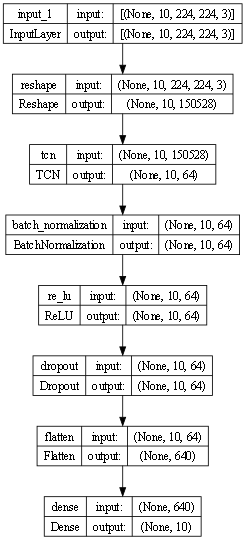

In [4]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [24]:
history = model.fit(x = train_ds,
                    epochs = 100, 
                    validation_data = val_ds)

Epoch 1/100
38/38 [==============================] - 35s 862ms/step - loss: 2.5628 - accuracy: 0.1567 - val_loss: 3.2957 - val_accuracy: 0.2400
Epoch 2/100
38/38 [==============================] - 33s 867ms/step - loss: 2.2936 - accuracy: 0.2200 - val_loss: 2.7936 - val_accuracy: 0.1900
Epoch 3/100
38/38 [==============================] - 32s 854ms/step - loss: 2.1204 - accuracy: 0.2833 - val_loss: 2.6181 - val_accuracy: 0.2500
Epoch 4/100
38/38 [==============================] - 32s 849ms/step - loss: 1.9977 - accuracy: 0.2967 - val_loss: 2.1179 - val_accuracy: 0.2500
Epoch 5/100
38/38 [==============================] - 32s 847ms/step - loss: 1.9124 - accuracy: 0.3433 - val_loss: 1.9497 - val_accuracy: 0.3100
Epoch 6/100
38/38 [==============================] - 32s 837ms/step - loss: 1.8392 - accuracy: 0.3300 - val_loss: 2.4255 - val_accuracy: 0.2500
Epoch 7/100
38/38 [==============================] - 32s 856ms/step - loss: 1.7834 - accuracy: 0.3567 - val_loss: 3.1034 - val_accuracy:

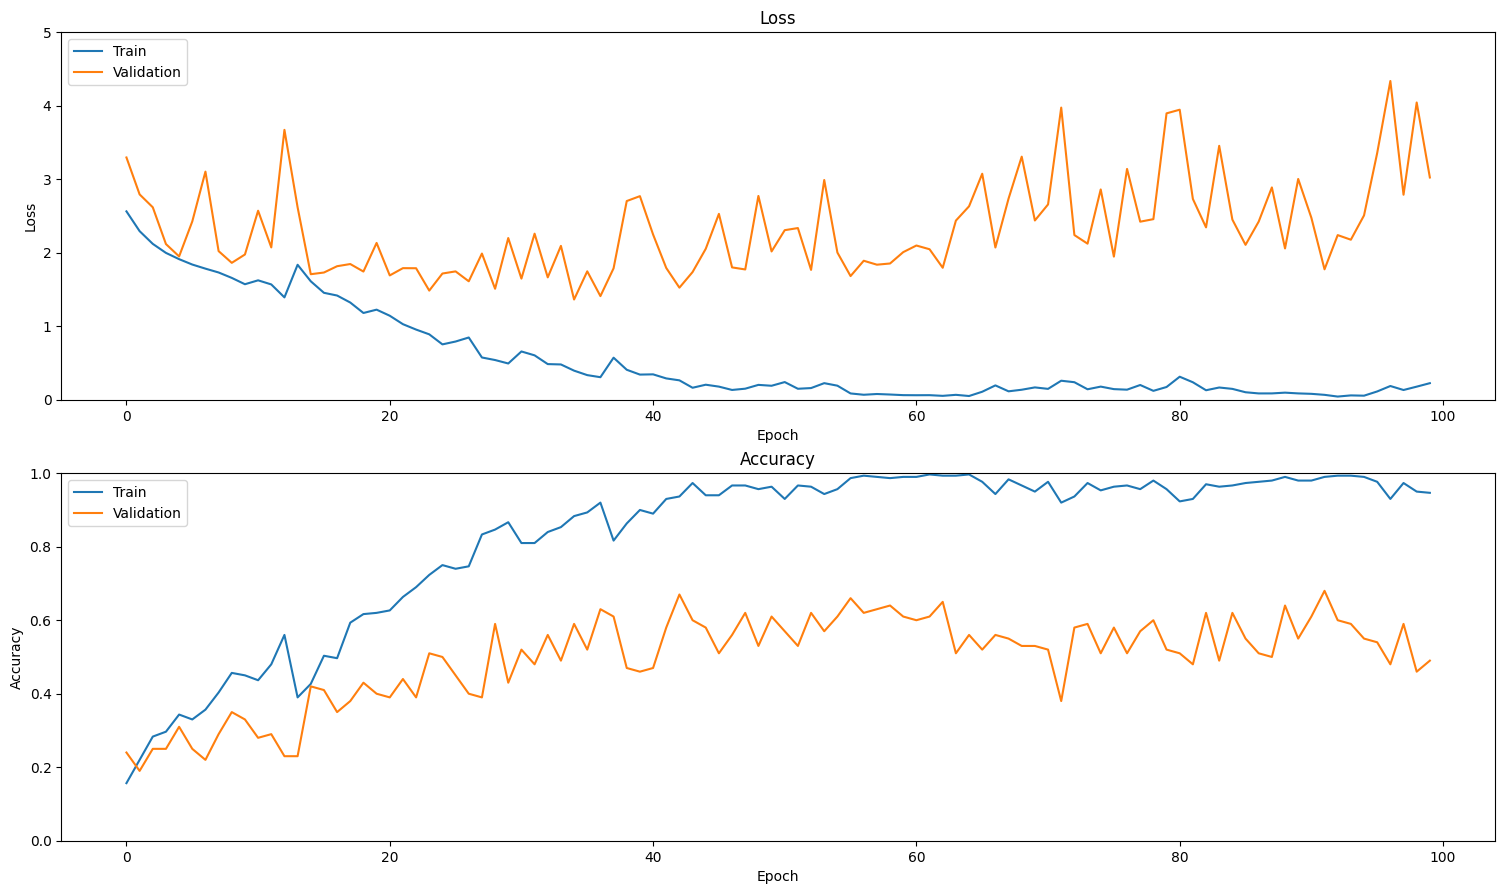

In [25]:
plot_history(history)

In [26]:

model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 9s 658ms/step - loss: 3.7329 - accuracy: 0.4100


{'loss': 3.732888698577881, 'accuracy': 0.4099999964237213}

13/13 [==============================] - 8s 613ms/step


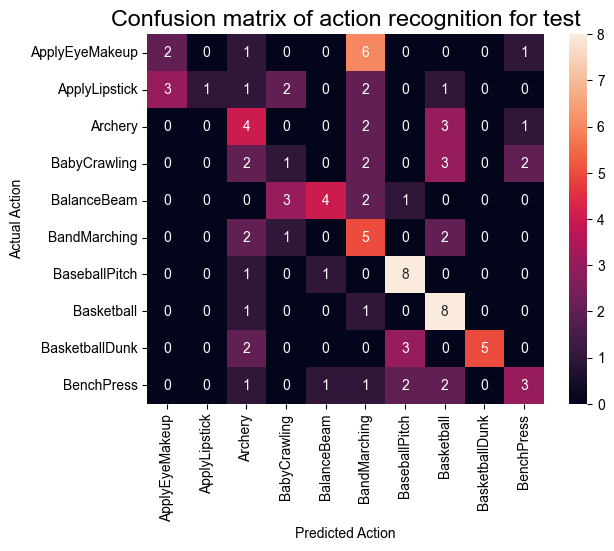

In [27]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')